In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from mlxtend.evaluate import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score


from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score

In [7]:
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import heatmap

In [8]:
from museotoolbox.ai import SuperLearner
from museotoolbox.cross_validation import RandomStratifiedKFold
from museotoolbox.charts import PlotConfusionMatrix
from museotoolbox import datasets
from sklearn.ensemble import RandomForestClassifier

In [9]:
import dtreeviz.trees
import dtreeviz
from sklearn.tree import plot_tree

In [10]:
from sklearn.model_selection import StratifiedKFold

In [11]:
df = pd.read_csv('ready_to_vote.csv', sep = ',')
df.head()

,Permeability coefficient,Accumulation_class,Charge,Canonical SMILES,name,FormalCharge,Ligand,glide rotatable bonds,docking score,glide ligand efficiency,...,A:85(PHE) HAccep nc,A:85(PHE) HAccep cc,A:85(PHE) HDonor nn,A:85(PHE) HDonor cn,A:85(PHE) XBond,A:85(PHE) Salt,A:85(PHE) PiCat,A:85(PHE) PiFace,A:85(PHE) PiEdge,A:85(PHE) HPhob
0,504.0,High,+ +,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,1,2,-6.671,-0.278,...,0,0,0,0,0,0,0,0,0,0
1,504.0,High,+ +,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,2,2,-6.615,-0.276,...,0,0,0,0,0,0,0,0,0,0
2,204.0,Low,+ +,COc1ccc2c(c1O)[C@@]13CC[NH2+][C@@H](C2)[C@H]1C...,2-11,2,3,3,-6.506,-0.283,...,0,0,0,0,0,0,0,0,0,0
3,504.0,High,+ +,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,4,2,-6.377,-0.266,...,0,0,0,0,0,0,0,0,0,0
4,504.0,High,+ +,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,2,5,2,-6.306,-0.263,...,0,0,0,0,0,0,0,0,0,0


In [12]:
FINAL= pd.read_csv('FINAL.csv', sep = ',')

int_table = pd.read_csv('glide-dock_nature_neutral_ph7.4_pv_interactions.csv', sep = ',')
binds = int_table['Type'].unique().tolist()

columns_bit_string = []

for property in FINAL.columns.tolist():
    if ((property[0] == 'A') and (property[-1] == ')')):
        columns_bit_string.append(property)

new_columns_names = []

for residue in columns_bit_string:
    for type in binds:
        bit = residue + ' ' + type
        new_columns_names.append(bit)

print('Interaction fingerprint: ', len(new_columns_names))

Interaction fingerprint:  784


## Feature selection based on interactions

In [13]:
list_left_residue = []
for residue in new_columns_names:
    if (df[residue] == df[residue][0]).all():
        #print('EMPTY', residue)
        df.drop(columns = [residue], axis = 1, inplace=True)
    else:
        list_left_residue.append(residue)

print('Interaction fingerprint left: ', len(list_left_residue))

# deleting interaction 1D fingerprint

df.drop(columns = ['interaction_1Dstring'], axis = 1, inplace=True)

Interaction fingerprint left:  176


# Sampling distribution (The Boltzmann distribution)

In [14]:
columns_no_change_1 = [ 'Canonical SMILES', 'name', 'Permeability coefficient', 'Accumulation_class', 'Charge','FormalCharge'] 
df_boltzmann = pd.DataFrame( columns=columns_no_change_1)

for name in df['name'].unique().tolist():
    #print(name)
    for_compound = df[df['name'] == name]
    df_boltzmann.loc[len(df_boltzmann)] = for_compound.loc[for_compound.index[0], columns_no_change_1].tolist()

df_boltzmann

,Canonical SMILES,name,Permeability coefficient,Accumulation_class,Charge,FormalCharge
0,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,504.0,High,+ +,2
1,COc1ccc2c(c1O)[C@@]13CC[NH2+][C@@H](C2)[C@H]1C...,2-11,204.0,Low,+ +,2
2,C=C1C[C@]23C[C@@]1(O)CC[C@H]2C1=C[C@@H](O)[C@H...,2-99,91.0,Low,±,0
3,COc1ccc2c(c1O)[C@@]13CC[N@H+](C)[C@@H](C2)[C@H...,4-2,1913.0,High,+,2
4,[NH3+][C@@H](CC(=O)N1CCn2c(nnc2C(F)(F)F)C1)Cc1...,4-36,275.0,Low,+,1
...,...,...,...,...,...,...
182,C=C1C[C@]23C[C@@]1(O)CC[C@@H]2c1cccc(C)c1[C@@H...,3-19,49.0,Low,neutral,0
183,NC(c1ccccc1)(c1ccccc1)c1ccccc1,4-63,0.0,Low,+,0
184,COC(=O)[C@]1(C)CCC[C@@]2(C)[C@H]1[C@@H](C[NH3+...,4-59,16.0,Low,+,1
185,COC(=O)[C@@H](C)NC[C@@]12CC[C@@H]3c4cccc(C)c4[...,2-28,16.0,Low,+,0


In [15]:
columns_no_change_2 = ['Permeability coefficient','Charge', 'Canonical SMILES', 'FormalCharge','name','Ligand'] 

columns_Boltzmann = []
for property in df.columns.tolist():
    if ((property[0] != 'A') and (property not in columns_no_change_2)):
        columns_Boltzmann.append(property)
#columns_Boltzmann

In [16]:
k=8.314
T = 298

for descriptor in columns_Boltzmann:
    descriptor_values = []
    
    for index_1 in df_boltzmann.index:
        name_antib = df_boltzmann.loc[index_1,'name']
        all_poses = df[df['name'] == name_antib]
        
        denominator = 0 
        for score in all_poses[descriptor]:
            numerator = np.exp(-(score  / (k*T))) 
            denominator = denominator + numerator

        feature = 0 
        prob = 0 

        for score in all_poses[descriptor]:
            numerator = np.exp(-(score  / (k*T)))
            prob_boltz = numerator / denominator
        
            feature = feature + score*prob_boltz
            prob = prob + prob_boltz

        descriptor_values.append(feature/prob)

    df_boltzmann[descriptor] = descriptor_values


In [17]:
df_boltzmann.head()

,Canonical SMILES,name,Permeability coefficient,Accumulation_class,Charge,FormalCharge,glide rotatable bonds,docking score,glide ligand efficiency,glide ligand efficiency sa,...,res:A42 vdw,res:A42 coul,res:A42 hbond,res:A42 dist,res:A42 Eint,res:A16 vdw,res:A16 coul,res:A16 hbond,res:A16 dist,res:A16 Eint
0,C=C1C[C@]23C[C@@]1(O)CC[C@H]2[C@@]12C=C[C@@H](...,2-6,504.0,High,+ +,2,2.0,-6.080552,-0.253357,-0.730715,...,-0.683670,35.044099,-0.008143,2.008951,34.352185,-0.277378,34.778827,-0.000357,4.218778,34.501177
1,COc1ccc2c(c1O)[C@@]13CC[NH2+][C@@H](C2)[C@H]1C...,2-11,204.0,Low,+ +,2,3.0,-5.353695,-0.232643,-0.661930,...,-1.070375,38.182736,-0.002786,2.600455,37.110153,-0.285708,35.369211,0.000000,4.579928,35.084173
2,C=C1C[C@]23C[C@@]1(O)CC[C@H]2C1=C[C@@H](O)[C@H...,2-99,91.0,Low,±,0,4.0,-4.747644,-0.197734,-0.570469,...,-1.260802,-21.680580,-0.113669,1.972250,-23.057792,-0.657862,-12.492551,0.000000,3.224580,-13.154587
3,COc1ccc2c(c1O)[C@@]13CC[N@H+](C)[C@@H](C2)[C@H...,4-2,1913.0,High,+,2,3.0,-4.133118,-0.179693,-0.510928,...,-0.711467,33.264071,-0.018462,3.371145,32.534105,-1.700206,41.126400,-0.012847,2.655215,39.414115
4,[NH3+][C@@H](CC(=O)N1CCn2c(nnc2C(F)(F)F)C1)Cc1...,4-36,275.0,Low,+,1,6.0,-5.638819,-0.201357,-0.611715,...,-0.465047,13.640812,0.000000,3.679621,13.175112,-0.453473,14.955573,0.000000,3.647044,14.500992


<Axes: xlabel='FormalCharge', ylabel='Permeability coefficient'>

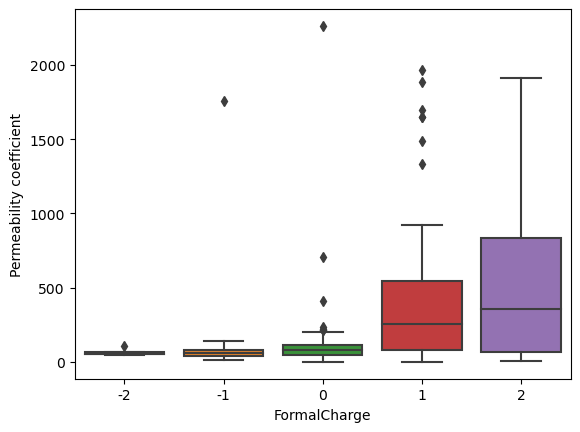

In [18]:
ax = sns.boxplot(data=df_boltzmann, x="FormalCharge", y="Permeability coefficient")
ax

## VOTING

In [19]:
threshold_list = [1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
voting_dict = dict() #only interactions
docking_interaction_dict = dict() #docking properties + interactions 
Saved_features_dict = dict() #saved interaction features after voting 

#### Code to vote with different thresholds

In [20]:
for number in threshold_list:
  #print("TRESHOLD: ", number)
  
  voting_dict[f"threshold_{number}"] = pd.DataFrame(columns=list_left_residue)  
  
  for name in df_boltzmann['name']:

    list_values_row = []
    #list_values_row.append(name)
    #print(name)

    small_data = df[df['name'] == name]
    #print(small_data.shape)

    threshold = small_data.shape[0]/number
    #print(small_data.shape[0], threshold)

    for residue  in list_left_residue: 
      sum_value = small_data[residue].sum()

      if sum_value >= threshold:
        list_values_row.append(1)
      else:
        list_values_row.append(0)
    
    #print(list_values_row)
    voting_dict[f"threshold_{number}"].loc[len(voting_dict[f"threshold_{number}"])] = list_values_row


#### Code to delete interactions which are no longer 1 and 0 (all values 0)

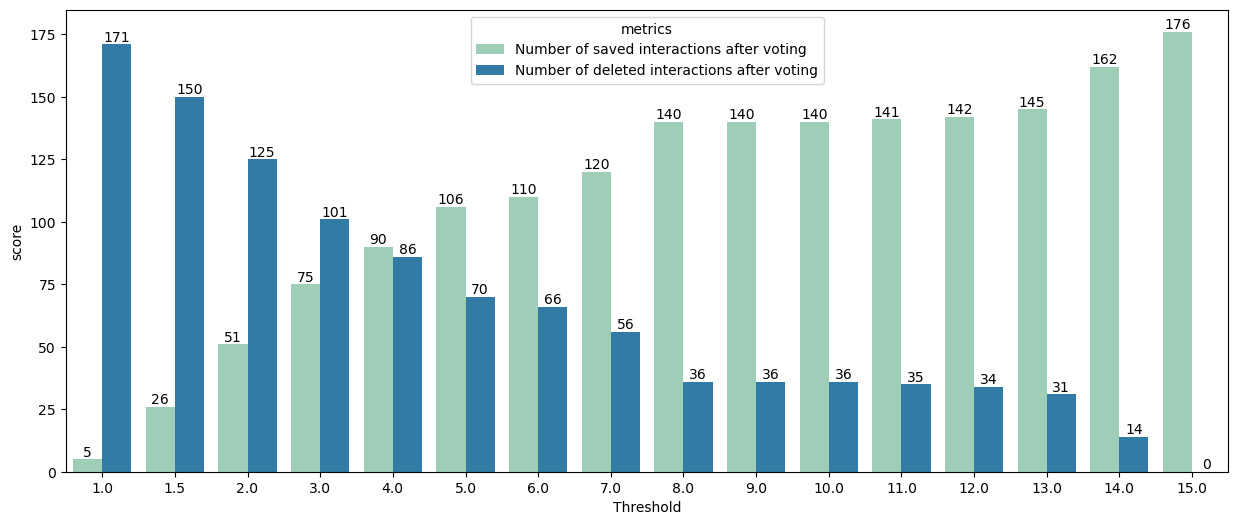

In [21]:
saved_deleted_interactions = pd.DataFrame(columns= ['Threshold' , 'Number of saved interactions after voting' , 'Number of deleted interactions after voting']) 

for number in threshold_list:
  #print("TRESHOLD: ", number)
  
  Saved_features_dict[f"threshold_{number}"] = []
  docking_interaction_dict[f"threshold_{number}"] = pd.DataFrame(columns=list_left_residue)

  myList_delete = []
  myList_save = []

  for residue in list_left_residue:
    sum_value = voting_dict[f"threshold_{number}"][residue].sum()

    if sum_value == 0:
      myList_delete.append(residue)
    else:
      myList_save.append(residue)

  Saved_features_dict[f"threshold_{number}"] = myList_save
  saved_deleted_interactions.loc[len(saved_deleted_interactions)] = [number, len(myList_save), len(myList_delete) ]

  voting_dict[f"threshold_{number}"] = voting_dict[f"threshold_{number}"][myList_save]

  #adding main properties
  docking_interaction_dict[f"threshold_{number}"] = pd.concat([df_boltzmann, voting_dict[f"threshold_{number}"]], axis=1)
  #docking_interaction_dict[f"threshold_{number}"] = pd.get_dummies(docking_interaction_dict[f"threshold_{number}"], columns=['Charge'], drop_first= False, dtype=float)
  docking_interaction_dict[f"threshold_{number}"] = docking_interaction_dict[f"threshold_{number}"].drop(['Charge'], axis =1)

  main_properties = ['name','Permeability coefficient', 'Accumulation_class']

  voting_dict[f"threshold_{number}"] = pd.concat([df_boltzmann[main_properties], voting_dict[f"threshold_{number}"]], axis=1)


plt.rcParams["figure.figsize"] = [15,6]
sns.light_palette("seagreen", as_cmap=True)
g = sns.barplot(
    data=pd.melt(
    saved_deleted_interactions, 
    id_vars= ['Threshold'], 
    value_vars=['Number of saved interactions after voting', 'Number of deleted interactions after voting'], 
    var_name='metrics', 
    value_name='score', 
    col_level=None
),
    x="Threshold", y="score", hue = "metrics", palette="YlGnBu")

g.bar_label(g.containers[1]) 
g.bar_label(g.containers[0]) 
plt.show()   


# EDA (asp113)

In [22]:
asp113 = 'A:113(ASP) '
glu117 = 'A:117(GLU) '

for number in threshold_list: 
    print('THRESHOLD: ', number)   
    features_ASP113 = []
    for feature_p in docking_interaction_dict[f"threshold_{number}"].columns.tolist():
        if feature_p[0:11] == asp113: #CHANGE IF YOU NEED ANOTHER TYPE OF INTERACTION !!!
            features_ASP113.append(feature_p)

    print("Features related to selected type of interaction", features_ASP113)

    asp113_table = docking_interaction_dict[f"threshold_{number}"][features_ASP113]
    #asp113_table

    new_column = []
    for ind_asp in asp113_table.index:
        int_sum = asp113_table.loc[ind_asp, :].sum()
        if int_sum == 0:
            new_column.append('0')
        else:
            new_column.append('1')

    docking_interaction_dict[f"threshold_{number}"]['interaction'] = new_column

    #ax = sns.boxplot(data=docking_interaction_dict[f"threshold_{number}"], x="FormalCharge" , y="Permeability coefficient", hue = 'interaction')
    ax.set(title=f"threshold_{number}")

    docking_interaction_dict[f"threshold_{number}"]= docking_interaction_dict[f"threshold_{number}"].drop(['interaction'], axis= 1)
    #plt.show()

THRESHOLD:  1
Features related to selected type of interaction ['A:113(ASP) HDonor nc']
THRESHOLD:  1.5
Features related to selected type of interaction ['A:113(ASP) HDonor nc', 'A:113(ASP) HDonor cn', 'A:113(ASP) Salt']
THRESHOLD:  2
Features related to selected type of interaction ['A:113(ASP) HDonor nc', 'A:113(ASP) HDonor nn', 'A:113(ASP) HDonor cn', 'A:113(ASP) Salt']
THRESHOLD:  3
Features related to selected type of interaction ['A:113(ASP) HDonor nc', 'A:113(ASP) HDonor nn', 'A:113(ASP) HDonor cn', 'A:113(ASP) Salt']
THRESHOLD:  4
Features related to selected type of interaction ['A:113(ASP) HDonor nc', 'A:113(ASP) HDonor nn', 'A:113(ASP) HDonor cn', 'A:113(ASP) Salt']
THRESHOLD:  5
Features related to selected type of interaction ['A:113(ASP) HDonor nc', 'A:113(ASP) HDonor nn', 'A:113(ASP) HDonor cn', 'A:113(ASP) Salt']
THRESHOLD:  6
Features related to selected type of interaction ['A:113(ASP) HDonor nc', 'A:113(ASP) HDonor nn', 'A:113(ASP) HDonor cn', 'A:113(ASP) Salt']
THRE

## Deleting correlated features

In [24]:
Corr_methos_saved_features_dict = dict() #saved features(docking properties + interactions) after correlation method
Corr_methos_deleted_features_dict = dict() #deleted features(docking properties + interactions) after correlation method

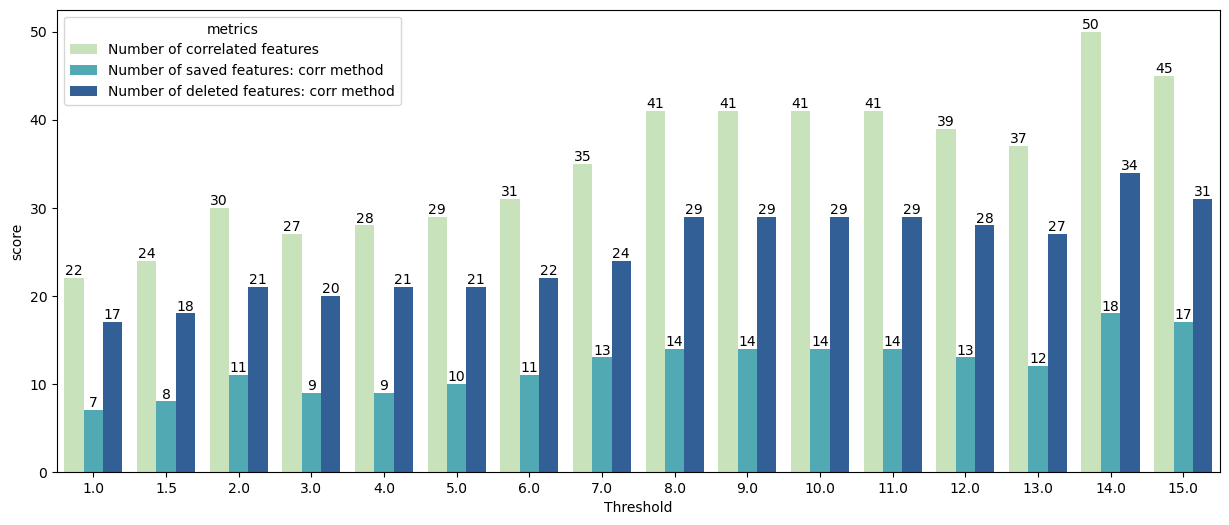

In [25]:
number_correlated_features = []
corr_method_saved_features = []
corr_method_deleted_features = []

for number in threshold_list:

    Corr_methos_saved_features_dict[f"threshold_{number}"] = []
    Corr_methos_deleted_features_dict[f"threshold_{number}"] = []

    #print("THRESHOLD: ", number)
    corr_matrix = docking_interaction_dict[f"threshold_{number}"].drop(['Canonical SMILES', 'name', 'Permeability coefficient',
        'Accumulation_class'], axis= 1).corr()

    corr_matrix_1 = corr_matrix.rename_axis('Feature').reset_index()


    correlation_data = pd.DataFrame(columns = ['Feature1', 'Feature2', 'Correlation coefficient'])
    properties = corr_matrix_1.columns.tolist()

    for feach1 in corr_matrix_1.index:
        for feach2 in properties[1:]:
            corr_coef = corr_matrix_1.loc[feach1, feach2]
            if 0.9 < corr_coef or corr_coef < -0.9:
                if corr_matrix_1.loc[feach1, 'Feature'] != feach2:
                    #correlation_data = correlation_data.append({'Feature1' : corr_matrix_1.loc[feach1, 'Feature'], 
                    # 'Feature2' : feach2, 'Correlation coefficient' : corr_coef}, ignore_index = True)
                    new_row = pd.DataFrame({'Feature1' : corr_matrix_1.loc[feach1, 'Feature'], 
                                        'Feature2' : feach2, 
                                        'Correlation coefficient' : corr_coef}, 
                                        index=[0])
                    correlation_data = pd.concat([new_row,correlation_data.loc[:]]).reset_index(drop=True)
        
    for index_cor in correlation_data.index:
        features = correlation_data.loc[index_cor, :].tolist()
        for index_corr_1 in correlation_data.index:
            features_2 = correlation_data.loc[index_corr_1, :].tolist()
            if features != features_2 and features_2[0] == features[1] and features_2[1] == features[0]:
                #print(features)
                #print('NEW',  features_2)
                #print('STOP')
                #print(index_cor,index_corr_1)
                correlation_data.drop(labels=index_cor, axis=0, inplace=True)
    #correlation_data

    feach1_list = correlation_data['Feature1'].unique().tolist()
    for item in correlation_data['Feature2'].unique().tolist():
        if item not in feach1_list:
            feach1_list.append(item)

    #print('Number of correlated features ', len(feach1_list))
    number_correlated_features.append(len(feach1_list))

    deleted_features = []
    saved_features = []
    deleted_indexes = []

    for index_f in correlation_data.index:
        #print(index_f)
        if index_f not in deleted_indexes:
            feature1 = correlation_data.loc[index_f, 'Feature1']
            feature2 = correlation_data.loc[index_f, 'Feature2']
            #print('Feature1: ',feature1)
            #print('Feature2: ',feature2)
            if feature2 not in deleted_features: 
                deleted_features.append(feature2)

            other_feach_list = correlation_data['Feature2'].tolist()[1:]
            #print(other_feach_list)
            correlation_data.drop(labels=index_f, axis=0, inplace=True)
            deleted_indexes.append(index_f)

            if feature1 in other_feach_list:
                #print('yes: feature is repeated')
                while (feature1 in other_feach_list): 
                    ind = correlation_data[correlation_data['Feature2'] == feature1].index[0]
                    #print(ind)
                    if feature1 not in deleted_features: 
                        deleted_features.append(feature1)
                    feature1 = correlation_data.loc[ind, 'Feature1']
                    #print('New feature1: ', feature1)
                    correlation_data.drop(labels=ind, axis=0, inplace=True)
                    deleted_indexes.append(ind)

                if feature1 not in saved_features:
                    saved_features.append(feature1)
            
            else:
                if feature1 not in deleted_features and feature1 not in saved_features:
                    saved_features.append(feature1)

            #print('SAVED FEATURES', saved_features)
            #print('DELETED FEATURES', deleted_features)
            #print('DELETED INDEXES', deleted_indexes)

    #print('SAVED FEATURES' , len(saved_features), saved_features)
    #print('DELETED FEATURES', len(deleted_features), deleted_features)

    corr_method_saved_features.append(len(saved_features))
    corr_method_deleted_features.append(len(deleted_features)) 

    Corr_methos_saved_features_dict[f"threshold_{number}"] = saved_features
    Corr_methos_deleted_features_dict[f"threshold_{number}"] = deleted_features

saved_deleted_interactions['Number of correlated features'] = number_correlated_features
saved_deleted_interactions['Number of saved features: corr method'] = corr_method_saved_features
saved_deleted_interactions['Number of deleted features: corr method'] = corr_method_deleted_features


plt.rcParams["figure.figsize"] = [15,6]
sns.light_palette("seagreen", as_cmap=True)
g = sns.barplot(
    data=pd.melt(
    saved_deleted_interactions, 
    id_vars= ['Threshold'], 
    value_vars=['Number of correlated features',
 'Number of saved features: corr method',
 'Number of deleted features: corr method'], 
    var_name='metrics', 
    value_name='score', 
    col_level=None
),
    x="Threshold", y="score", hue = "metrics", palette="YlGnBu")

g.bar_label(g.containers[1]) 
g.bar_label(g.containers[0]) 
g.bar_label(g.containers[2]) 
plt.show()   

In [27]:
number_feature_before_voting = len(df_boltzmann.columns.tolist()) - 5 + len(df_boltzmann['Charge'].unique().tolist()) + 176
saved_deleted_interactions["Number of features left"] = number_feature_before_voting - saved_deleted_interactions["Number of deleted interactions after voting"] - saved_deleted_interactions["Number of deleted features: corr method"]
saved_deleted_interactions

,Threshold,Number of saved interactions after voting,Number of deleted interactions after voting,Number of correlated features,Number of saved features: corr method,Number of deleted features: corr method,Number of features left
0,1.0,5.0,171.0,22,7,17,43.0
1,1.5,26.0,150.0,24,8,18,63.0
2,2.0,51.0,125.0,30,11,21,85.0
3,3.0,75.0,101.0,27,9,20,110.0
4,4.0,90.0,86.0,28,9,21,124.0
5,5.0,106.0,70.0,29,10,21,140.0
6,6.0,110.0,66.0,31,11,22,143.0
7,7.0,120.0,56.0,35,13,24,151.0
8,8.0,140.0,36.0,41,14,29,166.0
9,9.0,140.0,36.0,41,14,29,166.0


# Scaling

In [28]:
for number in threshold_list:
       
    columns_to_drop = ['Canonical SMILES', 'name', 'Permeability coefficient', 'Accumulation_class']

    df_pca = docking_interaction_dict[f"threshold_{number}"].drop(columns_to_drop, axis= 1)

    sc = StandardScaler()
    df_pca_transformed = sc.fit_transform(df_pca)

    scaled_data = pd.DataFrame(df_pca_transformed, columns = list(df_pca.columns))

    docking_interaction_dict[f"threshold_{number}"] =  pd.concat([docking_interaction_dict[f"threshold_{number}"][columns_to_drop], scaled_data], axis=1)

## Models

In [53]:
#classification model
X_class_dict = dict()
Y_class_dict = dict()

for number in threshold_list:

    #new column for classification model
    docking_interaction_dict[f"threshold_{number}"]['Permiation'] = [0 if x == 'Low' else 1 for x in docking_interaction_dict[f"threshold_{number}"]['Accumulation_class']]

    X_class_dict[f"threshold_{number}"] = docking_interaction_dict[f"threshold_{number}"].drop(['Canonical SMILES', 'name', 'Permeability coefficient', 'Accumulation_class', 'Permiation'], axis= 1)
    Y_class_dict[f"threshold_{number}"] = docking_interaction_dict[f"threshold_{number}"]['Permiation']

In [30]:
models = [['SVM', svm.SVC()], 
          ['Random Forest', RandomForestClassifier(random_state=42)], 
          ['Decision Tree', DecisionTreeClassifier(random_state=42)], 
          ['KNeighbors', KNeighborsClassifier()],
          ['LogisticRegression', LogisticRegression(random_state=42)]
          ]

def confusion_matrix_function(XXX, yyy, selected_features_mod, test_size):
    dict_test_train = {}
    for test_size_x in [test_size]:
        X_train, X_test, y_train, y_test = train_test_split(XXX, 
                                                        yyy, test_size=test_size_x, 
                                                        stratify=yyy, shuffle = True)
        #print(test_size_x)

        for name, classifier in models:
            #print(name)
            model = classifier
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            confmat = confusion_matrix(y_test, preds)

            #confusion matrix
            fig, axes = plt.subplots(1, 3, figsize=(17, 4))
            fig.suptitle(name, fontsize=16, x = 0.95)

            plot_confusion_matrix(conf_mat=confmat,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=False, axis = axes[0], figure = fig)
        

            #model with selected features

            X_train_sel = X_train[selected_features_mod]   
            X_test_sel = X_test[selected_features_mod] 

            model1 = classifier
            model1.fit(X_train_sel, y_train)
            preds_sel = model1.predict(X_test_sel)
            confmat_sel = confusion_matrix(y_test, preds_sel)
    
            plot_confusion_matrix(conf_mat=confmat_sel,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True, axis = axes[1], figure = fig )  
            
            #other metrics

            #standart accuracy 
            accuracy_all = round(accuracy_score(y_test, preds), 3)
            accuracy_sel = round(accuracy_score(y_test, preds_sel), 3)

            #balanced accuracy
            bal_acc_all = round(balanced_accuracy_score(y_test,preds), 3)
            bal_acc_sel = round(balanced_accuracy_score(y_test,preds_sel), 3)

            #recall
            recall_score_all = round(recall_score(y_test, preds, average='weighted'), 3)
            recall_score_sel = round(recall_score(y_test, preds_sel, average='weighted'), 3)

            #precision
            precision_all = round(precision_score(y_test, preds, zero_division = 1), 3)
            precision_sel = round(precision_score(y_test, preds_sel, zero_division = 1), 3)

            #ROC
            ROC_all = round(roc_auc_score(y_test, preds), 3)
            ROC_sel = round(roc_auc_score(y_test, preds_sel), 3)

            dict_metrics = {}
            dict_metrics[name + "_all"] = accuracy_all, bal_acc_all, recall_score_all, precision_all, ROC_all
            dict_metrics[name + "_sel"] = accuracy_sel, bal_acc_sel, recall_score_sel, precision_sel, ROC_sel

            metrics_dataframe = pd.DataFrame.from_dict(dict_metrics, orient='index',
                        columns=['Standart accuracy', 'Balanced accuracy', 'Recall', 'Precision', 'ROC'])
            new_metrics_dataframe = metrics_dataframe.rename_axis('Method').reset_index()
            melt_train_test = pd.melt(new_metrics_dataframe, 
                                    id_vars= ['Method'], 
                                    value_vars=('Standart accuracy', 'Balanced accuracy', 'Recall', 'Precision', 'ROC'), 
                                    var_name='metrics', 
                                    value_name='score', 
                                    col_level=None
                                    )
            #print(melt_train_test)


            sns.barplot(melt_train_test, x = 'Method', y = 'score', hue = 'metrics', ax = axes[2] )
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
            


            #print('Standart accuracy', accuracy_all, accuracy_sel)
            #print('Balanced accuracy', bal_acc_all, bal_acc_sel)
            #print('F1 score', f1_score_all, f1_score_sel)
            #print('Precision', precision_all, precision_sel) 
            #print('ROC', ROC_all, ROC_sel) 
            #print(dict_metrics)

            
            
            axes[0].set_title('all features')
            axes[1].set_title('selected features')

            plt.show()


In [54]:
ompF_features= ['res:A132 coul', 'res:A113 hbond', 'res:A16 dist', 'A:113(ASP) HDonor nc', 'A:113(ASP) Salt', 'A:132(ARG) HAccep cn', 'A:132(ARG) HAccep nn', 'A:132(ARG) Salt', 'A:16(LYS) HAccep cn', 'A:310(TYR) HPhob', 'A:40(TYR) HPhob', 'A:42(ARG) HAccep cn', 'A:42(ARG) HAccep nn', 'A:82(ARG) HAccep cn', 'A:82(ARG) HAccep nn', 'A:82(ARG) HAccep nc', 'A:82(ARG) Salt']
ompF_features

['res:A132 coul',
 'res:A113 hbond',
 'res:A16 dist',
 'A:113(ASP) HDonor nc',
 'A:113(ASP) Salt',
 'A:132(ARG) HAccep cn',
 'A:132(ARG) HAccep nn',
 'A:132(ARG) Salt',
 'A:16(LYS) HAccep cn',
 'A:310(TYR) HPhob',
 'A:40(TYR) HPhob',
 'A:42(ARG) HAccep cn',
 'A:42(ARG) HAccep nn',
 'A:82(ARG) HAccep cn',
 'A:82(ARG) HAccep nn',
 'A:82(ARG) HAccep nc',
 'A:82(ARG) Salt']

In [55]:
dict_metrics = {}

for number in threshold_list:
    #print('THRESOLD: ', number)
    
    for test_size_x in [0.3]:
        X_train, X_test, y_train, y_test = train_test_split(X_class_dict[f"threshold_{number}"], 
                                                        Y_class_dict[f"threshold_{number}"], test_size= test_size_x, 
                                                        stratify=Y_class_dict[f"threshold_{number}"], shuffle = True)
        #print(test_size_x)

        for name, classifier in models:
            #print(name)
            model = classifier
            model.fit(X_train, y_train)
            preds = model.predict(X_test)

            #model with selected features (after correlation method)
            #selected_features_mod = X_class_dict[f"threshold_{number}"].drop(Corr_methos_deleted_features_dict[f"threshold_{number}"], axis= 1).columns.tolist()
            
            #model with selected features (after OmpF small data)
            selected_features_mod = []
            for features_all in X_class_dict[f"threshold_{number}"].columns.tolist():
                if features_all in ompF_features:
                    selected_features_mod.append(features_all)
            #charge is important!
            selected_features_mod.append("FormalCharge")

            X_train_sel = X_train[selected_features_mod]   
            X_test_sel = X_test[selected_features_mod] 

            model1 = classifier
            model1.fit(X_train_sel, y_train)
            preds_sel = model1.predict(X_test_sel)
            
            #METRICS

            #standart accuracy 
            accuracy_all = round(accuracy_score(y_test, preds), 3)
            accuracy_sel = round(accuracy_score(y_test, preds_sel), 3)

            #balanced accuracy
            bal_acc_all = round(balanced_accuracy_score(y_test,preds), 3)
            bal_acc_sel = round(balanced_accuracy_score(y_test,preds_sel), 3)

            #recall score

            recall_score_all = round(recall_score(y_test, preds, average='weighted'), 3)
            recall_score_sel = round(recall_score(y_test, preds_sel, average='weighted'), 3)

            #precision
            precision_all = round(precision_score(y_test, preds, zero_division = 1), 3)
            precision_sel = round(precision_score(y_test, preds_sel, zero_division = 1), 3)

            #ROC
            ROC_all = round(roc_auc_score(y_test, preds), 3)
            ROC_sel = round(roc_auc_score(y_test, preds_sel), 3)

            
            dict_metrics["Thresold_" + str(number) + "_" + name + "_all"] = str(number), name, 'all', accuracy_all, bal_acc_all, recall_score_all, precision_all, ROC_all
            dict_metrics["Thresold_" + str(number) + "_" + name + "_selected"] = str(number), name, 'selected features' , accuracy_sel, bal_acc_sel, recall_score_sel, precision_sel, ROC_sel

            #print('Standart accuracy', accuracy_all, accuracy_sel)
            #print('Balanced accuracy', bal_acc_all, bal_acc_sel)
            #print('F1 score', f1_score_all, f1_score_sel)
            #print('Precision', precision_all, precision_sel) 
            #print('ROC', ROC_all, ROC_sel) 
            
metrics_dataframe = pd.DataFrame.from_dict(dict_metrics, orient='index', columns=['Threshold', 'Model','Number of features', 'Standart accuracy', 'Balanced accuracy', 'Recall', 'Precision', 'ROC'])
new_metrics_dataframe = metrics_dataframe.rename_axis('Method').reset_index()
new_metrics_dataframe


,Method,Threshold,Model,Number of features,Standart accuracy,Balanced accuracy,Recall,Precision,ROC
0,Thresold_1_SVM_all,1,SVM,all,0.842,0.708,0.842,0.750,0.708
1,Thresold_1_SVM_selected,1,SVM,selected features,0.772,0.500,0.772,1.000,0.500
2,Thresold_1_Random Forest_all,1,Random Forest,all,0.860,0.747,0.860,0.778,0.747
3,Thresold_1_Random Forest_selected,1,Random Forest,selected features,0.754,0.597,0.754,0.444,0.597
4,Thresold_1_Decision Tree_all,1,Decision Tree,all,0.772,0.635,0.772,0.500,0.635
...,...,...,...,...,...,...,...,...,...
155,Thresold_15_Decision Tree_selected,15,Decision Tree,selected features,0.719,0.628,0.719,0.400,0.628
156,Thresold_15_KNeighbors_all,15,KNeighbors,all,0.789,0.782,0.789,0.526,0.782
157,Thresold_15_KNeighbors_selected,15,KNeighbors,selected features,0.719,0.601,0.719,0.385,0.601
158,Thresold_15_LogisticRegression_all,15,LogisticRegression,all,0.807,0.740,0.807,0.571,0.740


SVM


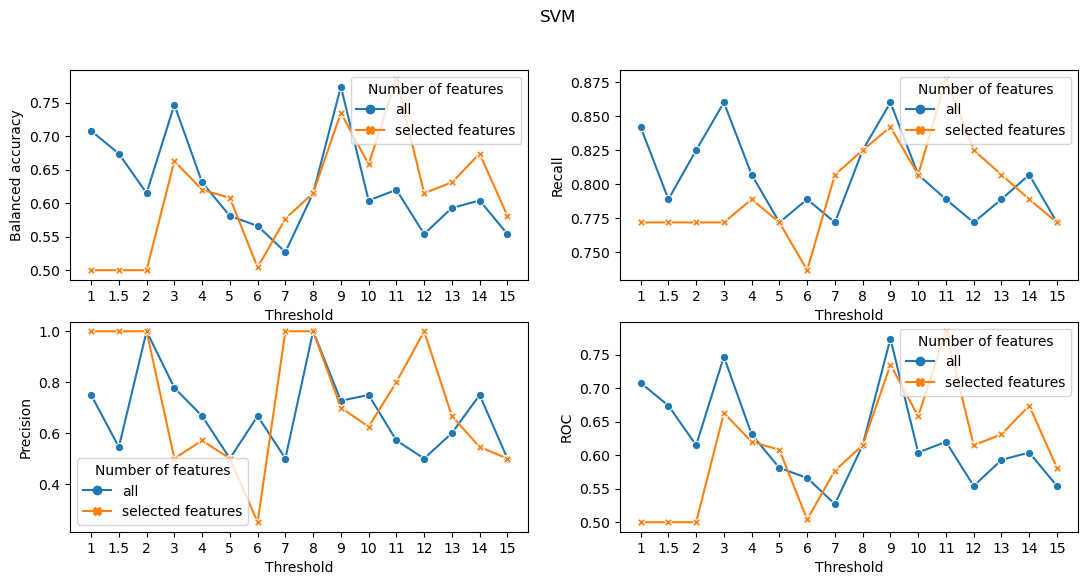

Random Forest


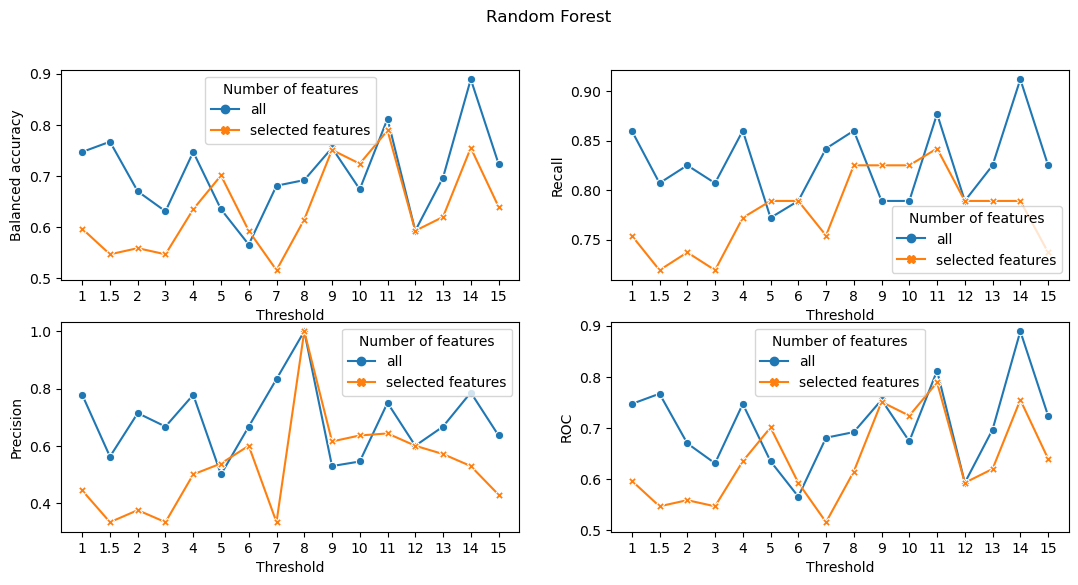

Decision Tree


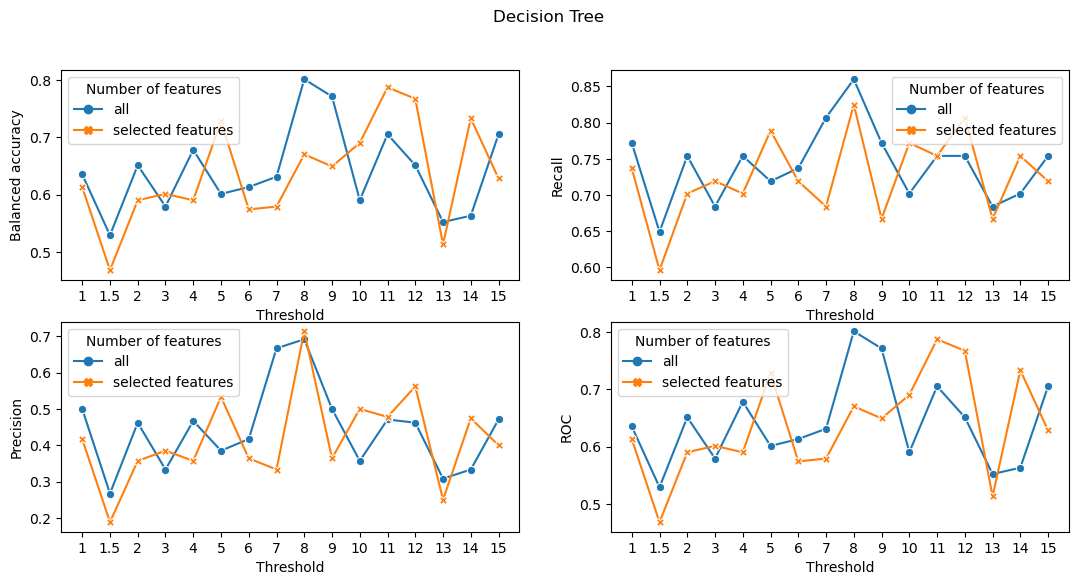

KNeighbors


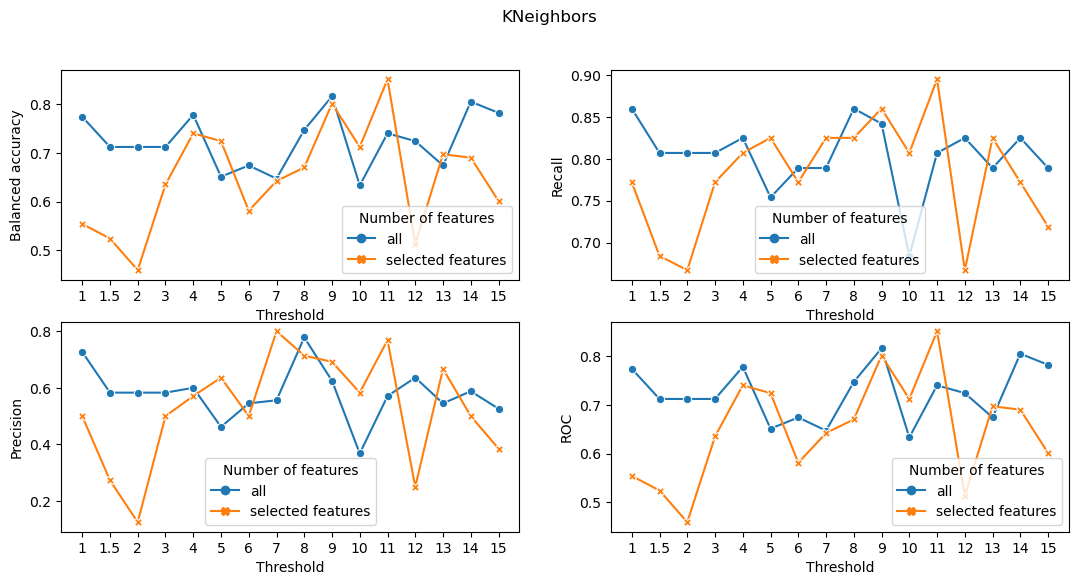

LogisticRegression


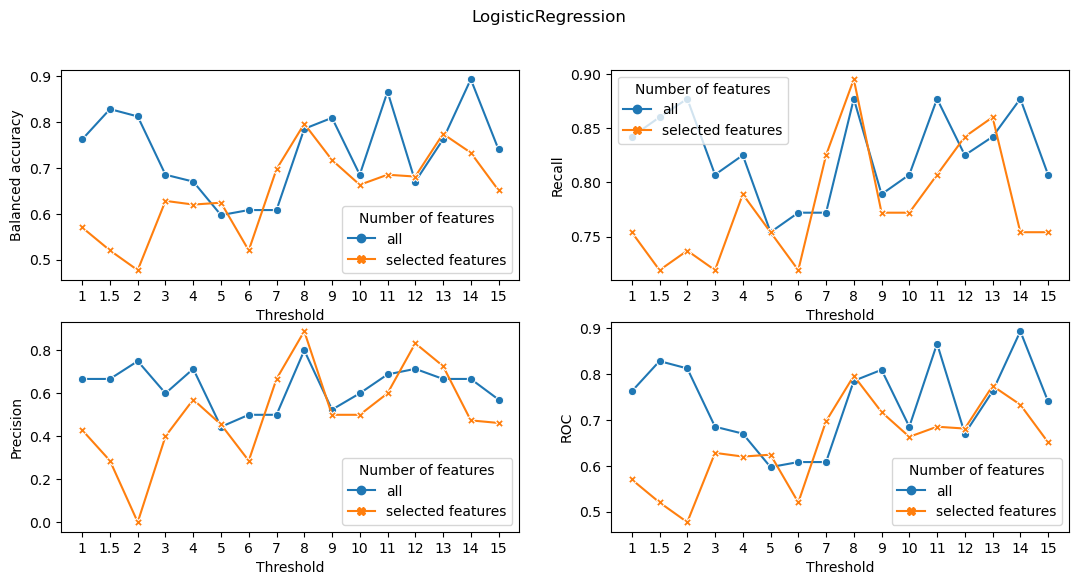

In [56]:
for name, classifier in models:
    fig, axes = plt.subplots(2, 2, figsize=(13, 6))
    fig.suptitle(name)
    print(name)
    sns.lineplot(ax=axes[0, 0], data=new_metrics_dataframe[new_metrics_dataframe['Model']== name], 
                      x="Threshold", y="Balanced accuracy", hue = 'Number of features',style ='Number of features',
                      markers=True, dashes=False)
    
    sns.lineplot(ax=axes[0, 1], data=new_metrics_dataframe[new_metrics_dataframe['Model']== name], 
                      x="Threshold", y="Recall", hue = 'Number of features',style ='Number of features',
                      markers=True, dashes=False)   
    
    sns.lineplot(ax=axes[1, 0], data=new_metrics_dataframe[new_metrics_dataframe['Model']== name], 
                      x="Threshold", y="Precision", hue = 'Number of features',style ='Number of features',
                      markers=True, dashes=False) 
    
    sns.lineplot(ax=axes[1, 1], data=new_metrics_dataframe[new_metrics_dataframe['Model']== name], 
                      x="Threshold", y="ROC", hue = 'Number of features',style ='Number of features',
                      markers=True, dashes=False) 
    
    plt.show()

Selected features:  18
['res:A132 coul', 'res:A113 hbond', 'res:A16 dist', 'A:113(ASP) HDonor nc', 'A:113(ASP) Salt', 'A:132(ARG) HAccep cn', 'A:132(ARG) HAccep nn', 'A:132(ARG) Salt', 'A:16(LYS) HAccep cn', 'A:310(TYR) HPhob', 'A:40(TYR) HPhob', 'A:42(ARG) HAccep cn', 'A:42(ARG) HAccep nn', 'A:82(ARG) HAccep cn', 'A:82(ARG) HAccep nn', 'A:82(ARG) HAccep nc', 'A:82(ARG) Salt', 'FormalCharge']


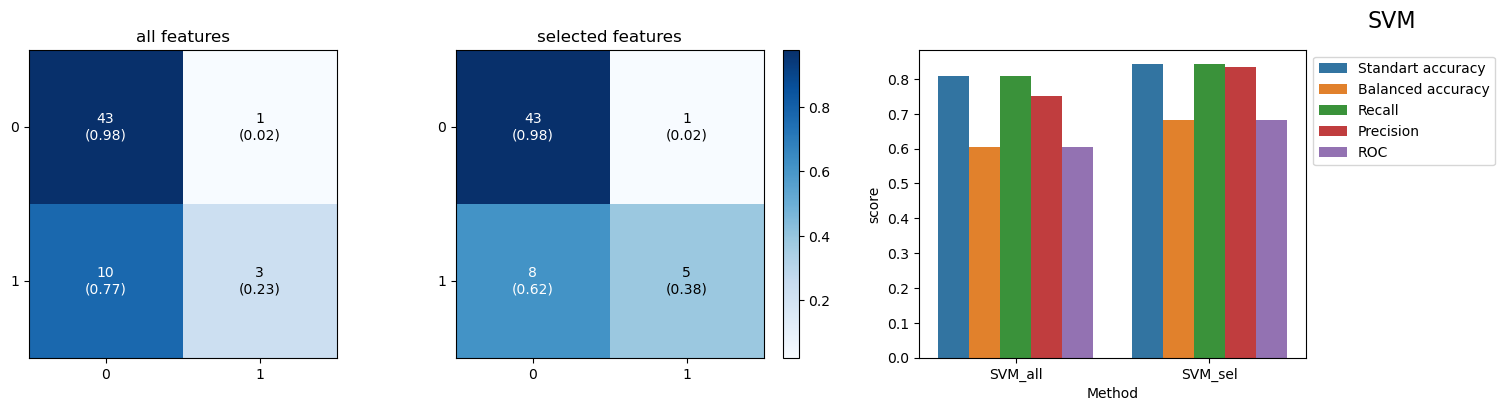

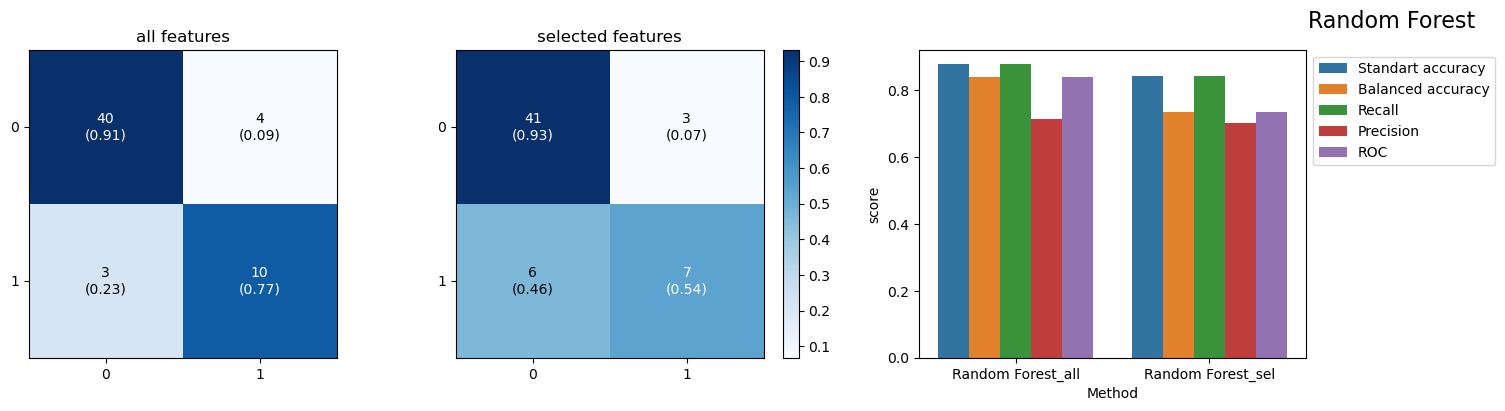

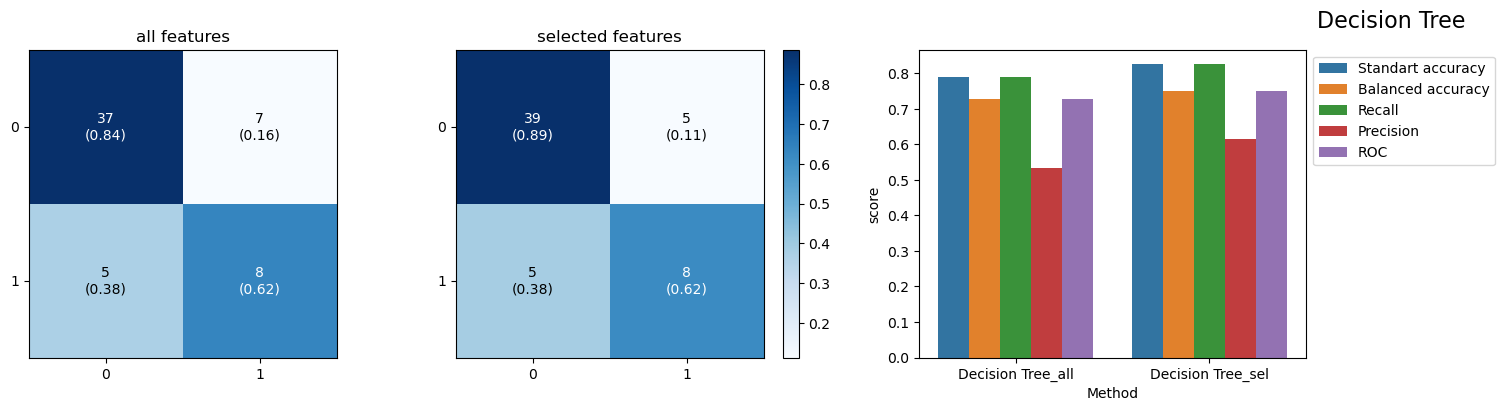

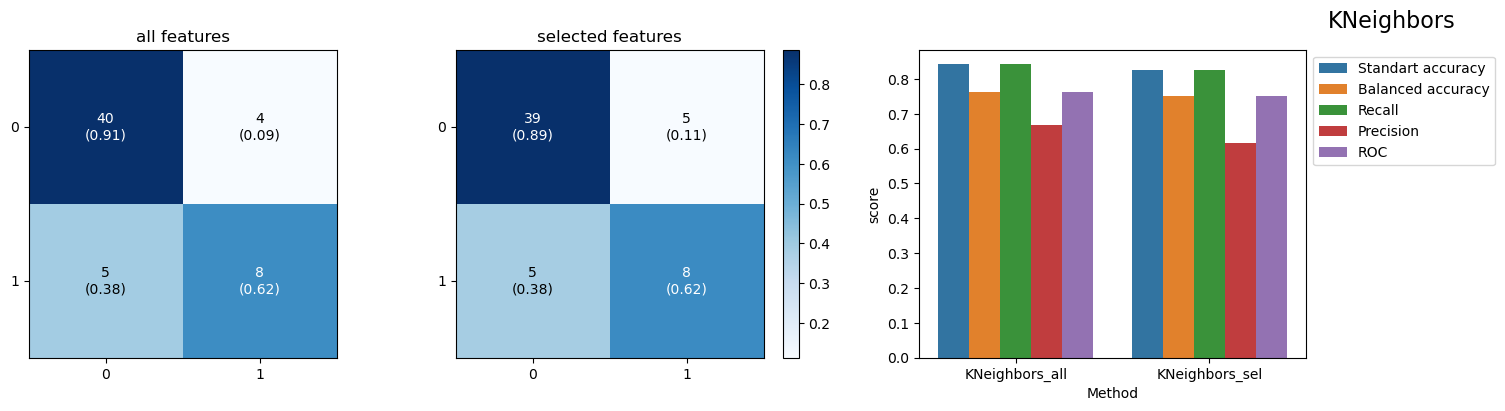

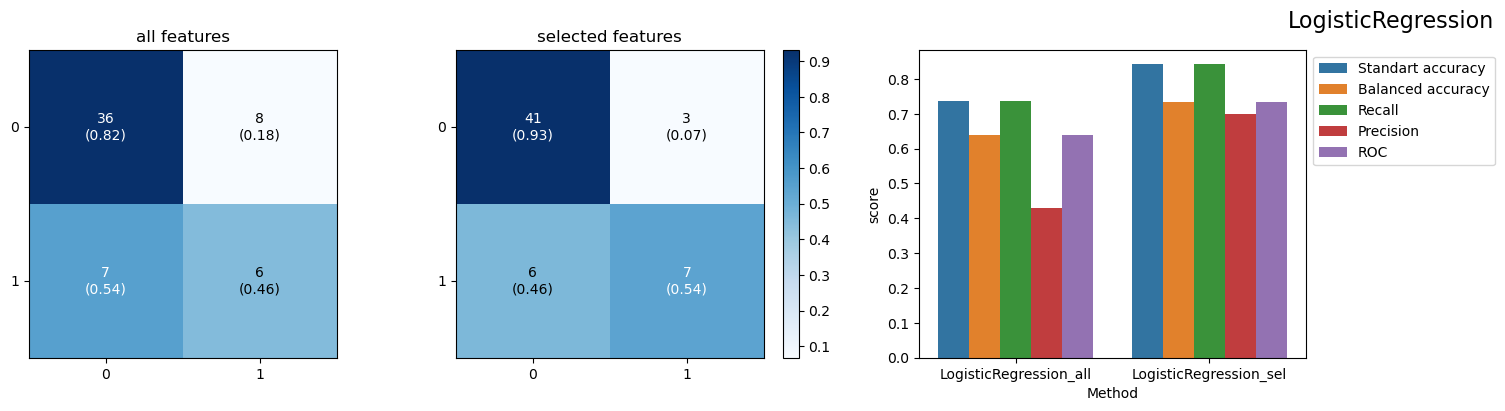

In [124]:
selected_treshold = [6]
for number in selected_treshold:
    #select_features = X_class_dict[f"threshold_{number}"].drop(Corr_methos_deleted_features_dict[f"threshold_{number}"], axis= 1).columns.tolist()
    #.drop(Corr_methos_deleted_features_dict[f"threshold_{number}"], axis= 1).columns.tolist()

    select_features = []
    for features_all in X_class_dict[f"threshold_{number}"].columns.tolist():
        if features_all in ompF_features:
            select_features.append(features_all)

    select_features.append("FormalCharge")
    print("Selected features: ", len(select_features))
    print(select_features)

    confusion_matrix_function(X_class_dict[f"threshold_{number}"], Y_class_dict[f"threshold_{number}"], select_features, 0.3)

Decision Tree


c:\Users\olshana1\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


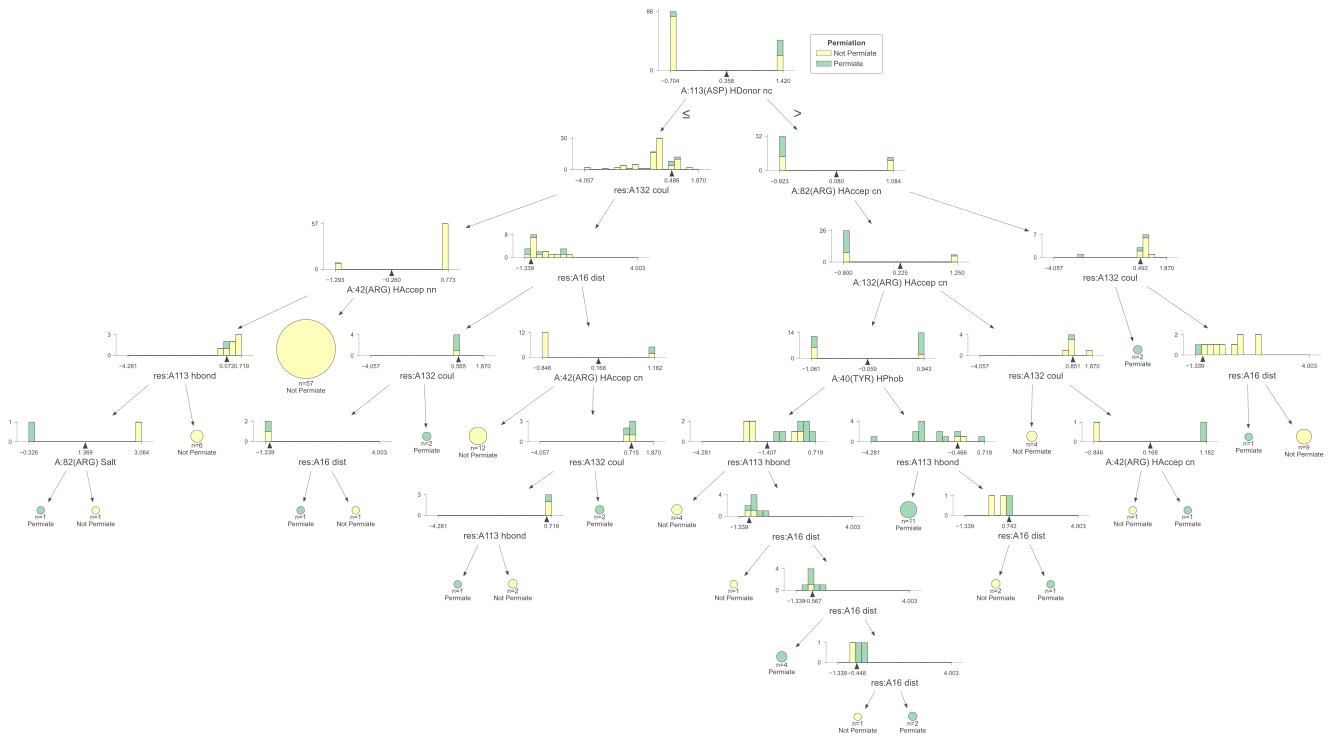

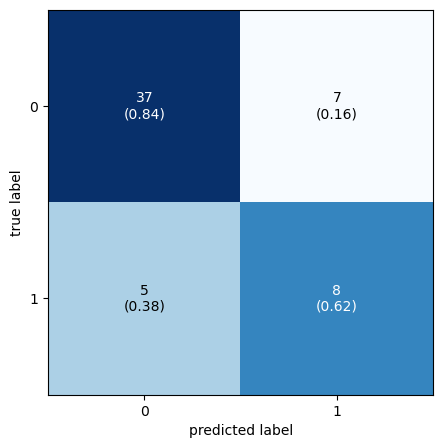

In [101]:
threshold_list = [12]

for number in threshold_list:
    #print('THRESOLD: ', number)
    select_features = []
    for features_all in X_class_dict[f"threshold_{number}"].columns.tolist():
        if features_all in ompF_features:
            select_features.append(features_all)
    select_features.append("FormalCharge")
    
    for test_size_x in [0.3]:
        X_train, X_test, y_train, y_test = train_test_split(X_class_dict[f"threshold_{number}"][select_features], 
                                                        Y_class_dict[f"threshold_{number}"], test_size= test_size_x, 
                                                        random_state=42, stratify=Y_class_dict[f"threshold_{number}"], shuffle = True)
        #print(test_size_x)

        for name, model in models:
            if name == 'Decision Tree':
                print(name)
                model.fit(X_train, y_train)

                #plot_tree(model, filled=True, rounded=True) 
                #plt.show()
                viz_model = dtreeviz.model(model,
                            X_train=X_train, y_train=y_train,
                            feature_names=X_train.columns,
                            target_name='Permiation',
                            class_names=['Not Permiate', 'Permiate'],)
                
                preds = model.predict(X_test)
                confmat = confusion_matrix(y_test, preds)
                plot_confusion_matrix(conf_mat=confmat,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=False)


            

viz_model.view()
            

# Cross fold validation

In [92]:
models

[['SVM', SVC()],
 ['Random Forest', RandomForestClassifier(random_state=42)],
 ['Decision Tree', DecisionTreeClassifier(random_state=42)],
 ['KNeighbors', KNeighborsClassifier()],
 ['LogisticRegression', LogisticRegression(random_state=42)]]

In [102]:
folds_names = []
number_of_folds = 7
for i in range(number_of_folds):
    folds_names.append(f"fold_{i+1}")

boxplot_cross_val = pd.DataFrame(columns = ["Model", "Threshold", "Metric"] + folds_names)
boxplot_cross_val

,Model,Threshold,Metric,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7


Selected features:  6
['res:A132 coul', 'res:A113 hbond', 'res:A16 dist', 'A:113(ASP) HDonor nc', 'A:40(TYR) HPhob', 'FormalCharge']
Selected features:  15
['res:A132 coul', 'res:A113 hbond', 'res:A16 dist', 'A:113(ASP) HDonor nc', 'A:113(ASP) Salt', 'A:132(ARG) HAccep cn', 'A:132(ARG) HAccep nn', 'A:132(ARG) Salt', 'A:40(TYR) HPhob', 'A:42(ARG) HAccep cn', 'A:42(ARG) HAccep nn', 'A:82(ARG) HAccep cn', 'A:82(ARG) HAccep nn', 'A:82(ARG) Salt', 'FormalCharge']
Selected features:  17
['res:A132 coul', 'res:A113 hbond', 'res:A16 dist', 'A:113(ASP) HDonor nc', 'A:113(ASP) Salt', 'A:132(ARG) HAccep cn', 'A:132(ARG) HAccep nn', 'A:132(ARG) Salt', 'A:16(LYS) HAccep cn', 'A:310(TYR) HPhob', 'A:40(TYR) HPhob', 'A:42(ARG) HAccep cn', 'A:42(ARG) HAccep nn', 'A:82(ARG) HAccep cn', 'A:82(ARG) HAccep nn', 'A:82(ARG) Salt', 'FormalCharge']
Selected features:  18
['res:A132 coul', 'res:A113 hbond', 'res:A16 dist', 'A:113(ASP) HDonor nc', 'A:113(ASP) Salt', 'A:132(ARG) HAccep cn', 'A:132(ARG) HAccep nn'

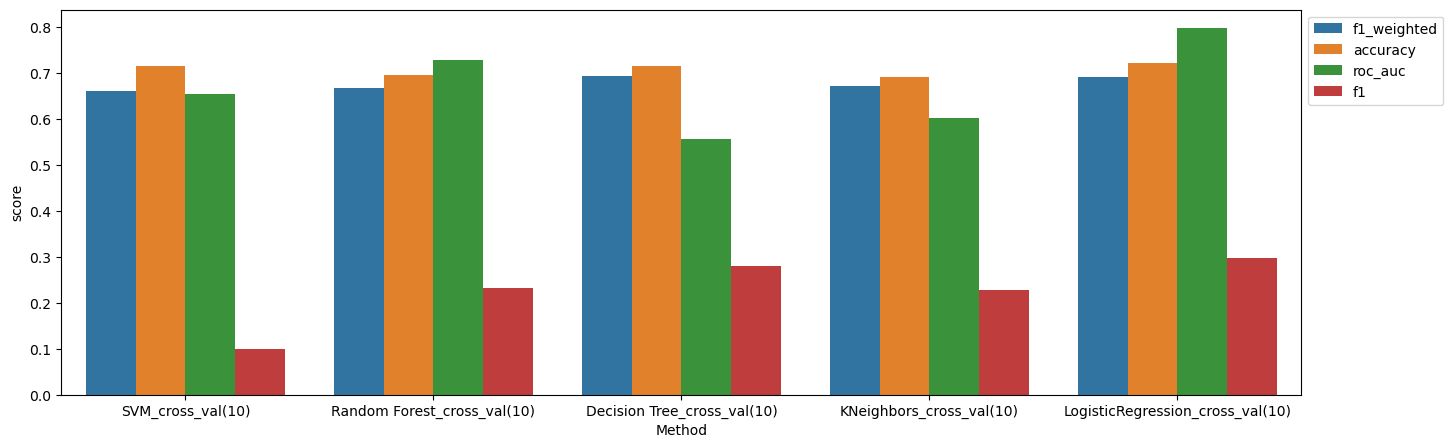

In [103]:
threshold_list = [1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for number in threshold_list:
    
    skf = StratifiedKFold(n_splits=number_of_folds)
    skf.get_n_splits(X_class_dict[f"threshold_{number}"], Y_class_dict[f"threshold_{number}"])

    my_dictionary = {}
    metrics = ['f1_weighted', 'accuracy', 'roc_auc', 'f1']

    #model with selected features (after OmpF small data)
    selected_features_mod = []
    for features_all in X_class_dict[f"threshold_{number}"].columns.tolist():
        if features_all in ompF_features:
            selected_features_mod.append(features_all)
    #charge is important!
    selected_features_mod.append("FormalCharge")
    print("Selected features: ", len(selected_features_mod))
    print(selected_features_mod)

    for name, model in models:
    
        scores = cross_validate(model, X_class_dict[f"threshold_{number}"][selected_features_mod],
                            Y_class_dict[f"threshold_{number}"], cv=skf, scoring=metrics)

        #boxplot for accuracy and f1
        values = [name, number, 'Accuracy'] + scores['test_accuracy'].tolist()
        boxplot_cross_val.loc[len(boxplot_cross_val)] = values

        #values_f1 = [name, number, 'f1'] + scores['test_f1'].tolist()
        #boxplot_cross_val.loc[len(boxplot_cross_val)] = values_f1

        #values_f1_weited = [name, number, 'f1_weited'] + scores['test_f1_weighted'].tolist()
        #boxplot_cross_val.loc[len(boxplot_cross_val)] = values_f1_weited

        dict_list = []
        for type_score in ['test_f1_weighted', 'test_accuracy', 'test_roc_auc', 'test_f1']:
            variable = round(scores[type_score].mean(), 3) 
            dict_list.append(variable)


        my_dictionary[name + "_"  + 'cross_val(10)'] = dict_list

    cross_val = pd.DataFrame.from_dict(my_dictionary, orient='index',
                       columns=['f1_weighted', 'accuracy', 'roc_auc', 'f1'])

    new_cross_val = cross_val.rename_axis('Method').reset_index()

    melt_cross_val = pd.melt(
        new_cross_val, 
        id_vars= ['Method'],
        value_vars=('f1_weighted','accuracy', 'roc_auc', 'f1'), 
        var_name='metrics', 
        value_name='score', 
        col_level=None
        )
    
#melt_cross_val

plt.rcParams["figure.figsize"] = [16,5]
sns.barplot(melt_cross_val, x = 'Method', y = 'score', hue = 'metrics')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

<Axes: xlabel='Threshold', ylabel='value'>

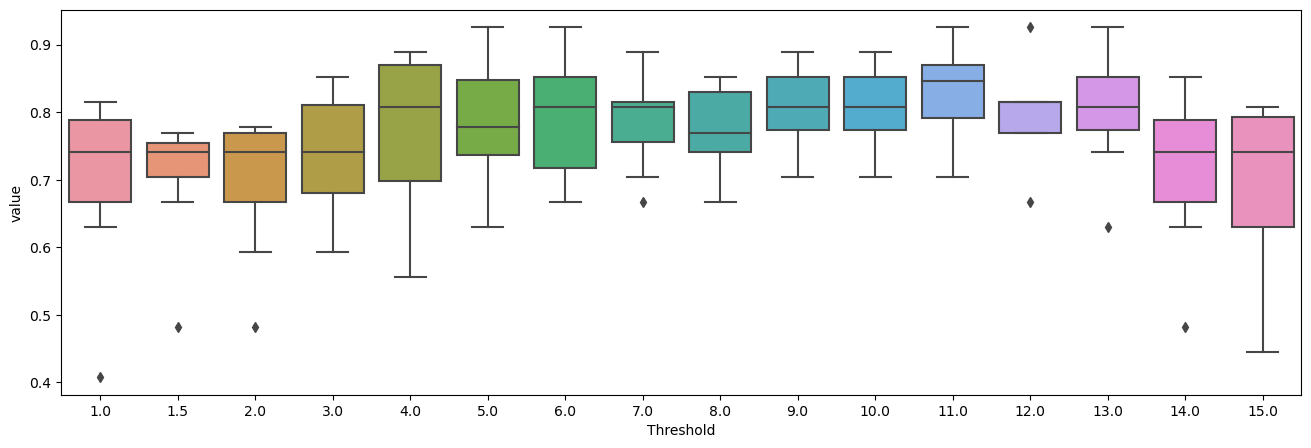

In [111]:
melt_boxplot = pd.melt(
        boxplot_cross_val, 
        id_vars= ['Model', 'Threshold', "Metric"],
        value_vars=(folds_names), 
        var_name='folds_names', 
        value_name='value', 
        col_level=None
        )
pp = melt_boxplot[melt_boxplot['Model'] == 'KNeighbors']

sns.boxplot(data=pp, x="Threshold", y="value")
#, hue="Metric")
#sns.stripplot(x = "Threshold", y = "value", color = 'black', alpha = 0.8, data = pp)

In [58]:
models_test = [ 
          ['Decision Tree', DecisionTreeClassifier(random_state=42)], 
          ]

In [63]:
def grid_search_function(XXX, yyy, test_size):
    dict_test_train = {}
    for test_size_x in [test_size]:
        X_train, X_test, y_train, y_test = train_test_split(XXX, 
                                                        yyy, test_size=test_size, 
                                                        random_state=42, stratify=yyy, shuffle = True)

        param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, None],
               'criterion': ['gini', 'entropy']}]
        
        for name, classifier in models_test:
            gs = GridSearchCV(estimator=classifier,
                  param_grid=param_grid,
                  refit=True,
                  cv=10,
                  n_jobs=None)

            gs.fit(X_train, y_train)

            print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
            print('Best Params:', gs.best_params_)

            # gs.best_estimator_.fit(X_train, y_train)
            print('Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

            grid = np.zeros((2, 7))
            grid[0, :] = gs.cv_results_['mean_test_score'][:7]
            grid[1, :] = gs.cv_results_['mean_test_score'][7:]


            heatmap(grid, 
                    column_names=[1, 2, 3, 4, 5, 6, "None"], 
                    row_names=['gini', 'entropy'])
            plt.ylabel('Criterion')
            plt.xlabel('Max depth')
            plt.show()


Best Accuracy: 77.69%
Best Params: {'criterion': 'entropy', 'max_depth': 1}
Accuracy: 77.19%


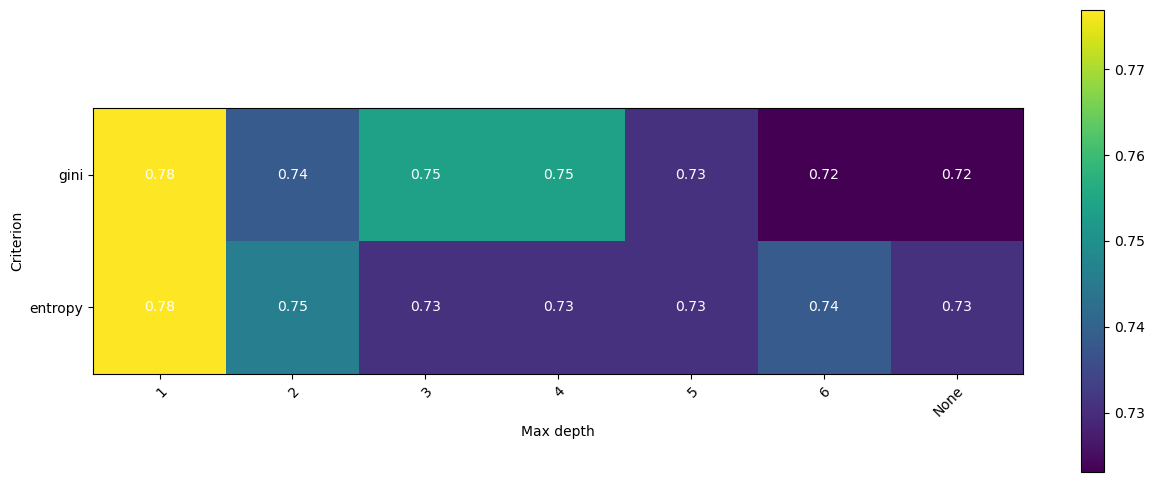

In [66]:
selected_treshold = [2]
for number in selected_treshold:
    grid_search_function(X_class_dict[f"threshold_{number}"], Y_class_dict[f"threshold_{number}"], 0.3)

In [ ]:
grid_search_function(XXX, yyy, test_size)

In [ ]:
def grid_search_function(XXX, yyy, selected_features_mod, test_size):
    dict_test_train = {}
    for test_size_x in [test_size]:
        X_train, X_test, y_train, y_test = train_test_split(XXX, 
                                                        yyy, test_size=test_size, 
                                                        random_state=42, stratify=yyy, shuffle = True)
        #print(test_size_x)

        for name, classifier in models:
            #print(name)
            model = classifier
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            confmat = confusion_matrix(y_test, preds)

            #confusion matrix
            fig, axes = plt.subplots(1, 3, figsize=(17, 4))
            fig.suptitle(name, fontsize=16, x = 0.95)

            plot_confusion_matrix(conf_mat=confmat,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=False, axis = axes[0], figure = fig)
        

            #model with selected features

            X_train_sel = X_train[selected_features_mod]   
            X_test_sel = X_test[selected_features_mod] 

            model1 = classifier
            model1.fit(X_train_sel, y_train)
            preds_sel = model1.predict(X_test_sel)
            confmat_sel = confusion_matrix(y_test, preds_sel)
    
            plot_confusion_matrix(conf_mat=confmat_sel,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True, axis = axes[1], figure = fig )  
            
            #other metrics

            #standart accuracy 
            accuracy_all = round(accuracy_score(y_test, preds), 3)
            accuracy_sel = round(accuracy_score(y_test, preds_sel), 3)

            #balanced accuracy
            bal_acc_all = round(balanced_accuracy_score(y_test,preds), 3)
            bal_acc_sel = round(balanced_accuracy_score(y_test,preds_sel), 3)

            #f1 score
            f1_score_all = round(f1_score(y_test, preds), 3)
            f1_score_sel = round(f1_score(y_test, preds_sel), 3)

            #precision
            precision_all = round(precision_score(y_test, preds, zero_division = 1), 3)
            precision_sel = round(precision_score(y_test, preds_sel, zero_division = 1), 3)

            #ROC
            ROC_all = round(roc_auc_score(y_test, preds), 3)
            ROC_sel = round(roc_auc_score(y_test, preds_sel), 3)

            dict_metrics = {}
            dict_metrics[name + "_all"] = accuracy_all, bal_acc_all, f1_score_all, precision_all, ROC_all
            dict_metrics[name + "_sel"] = accuracy_sel, bal_acc_sel, f1_score_sel, precision_sel, ROC_sel

            metrics_dataframe = pd.DataFrame.from_dict(dict_metrics, orient='index',
                        columns=['Standart accuracy', 'Balanced accuracy', 'F1 score', 'Precision', 'ROC'])
            new_metrics_dataframe = metrics_dataframe.rename_axis('Method').reset_index()
            melt_train_test = pd.melt(new_metrics_dataframe, 
                                    id_vars= ['Method'], 
                                    value_vars=('Standart accuracy', 'Balanced accuracy', 'F1 score', 'Precision', 'ROC'), 
                                    var_name='metrics', 
                                    value_name='score', 
                                    col_level=None
                                    )
            #print(melt_train_test)


            sns.barplot(melt_train_test, x = 'Method', y = 'score', hue = 'metrics', ax = axes[2] )
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
            


            #print('Standart accuracy', accuracy_all, accuracy_sel)
            #print('Balanced accuracy', bal_acc_all, bal_acc_sel)
            #print('F1 score', f1_score_all, f1_score_sel)
            #print('Precision', precision_all, precision_sel) 
            #print('ROC', ROC_all, ROC_sel) 
            #print(dict_metrics)

            
            
            axes[0].set_title('all features')
            axes[1].set_title('selected features')

            plt.show()